# Import Packages

In [13]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from pathlib import Path

# Load Match Data

In [2]:
# Load the CSV file into a DataFrame
matches_csv_path = "Data/matches_3.csv"
matches_df = pd.read_csv(matches_csv_path)

# Display the DataFrame
matches_df.head()

,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_player_1,home_player_2,...,away_team_formation,home_team_num_defenders,home_team_num_midfielders,home_team_num_attackers,away_team_num_defenders,away_team_num_midfielders,away_team_num_attackers,Year,Month,day
0,4769,4769,2008/2009,1,2008-08-09,483134,9829,9847,145039.0,41097.0,...,4-4-2,4,4,2,4,4,2,2008,8,9
1,4769,4769,2008/2009,1,2008-08-10,483133,9748,9941,26295.0,26162.0,...,4-3-3,4,3,3,4,3,3,2008,8,10
2,1729,1729,2008/2009,1,2008-08-16,489043,9825,8659,23686.0,26111.0,...,4-5-1,4,4,2,4,5,1,2008,8,16
3,1729,1729,2008/2009,1,2008-08-16,489044,8472,8650,32562.0,38836.0,...,4-4-2,4,4,2,4,4,2,2008,8,16
4,1729,1729,2008/2009,1,2008-08-16,489050,8667,9879,23021.0,34430.0,...,4-4-2,4,4,2,4,4,2,2008,8,16


# Data Format conversion

In [3]:
# make these columns as string to apply one hot encoding
matches_df["country_id"] = matches_df["country_id"].astype(str)
matches_df["league_id"] = matches_df["league_id"].astype(str)
matches_df["match_api_id"] = matches_df["match_api_id"].astype(str)
matches_df["home_team_api_id"] = matches_df["home_team_api_id"].astype(str)
matches_df["away_team_api_id"] = matches_df["away_team_api_id"].astype(str)
matches_df["season"] = matches_df["season"].astype(str)
matches_df["home_player_1"] = matches_df["home_player_1"].astype(str)
matches_df["home_player_2"] = matches_df["home_player_2"].astype(str)
matches_df["home_player_3"] = matches_df["home_player_3"].astype(str)
matches_df["home_player_4"] = matches_df["home_player_4"].astype(str)
matches_df["home_player_5"] = matches_df["home_player_5"].astype(str)
matches_df["home_player_6"] = matches_df["home_player_6"].astype(str)
matches_df["home_player_7"] = matches_df["home_player_7"].astype(str)
matches_df["home_player_8"] = matches_df["home_player_8"].astype(str)
matches_df["home_player_9"] = matches_df["home_player_9"].astype(str)
matches_df["home_player_10"] = matches_df["home_player_10"].astype(str)
matches_df["home_player_11"] = matches_df["home_player_11"].astype(str)
matches_df["away_player_1"] = matches_df["away_player_1"].astype(str)
matches_df["away_player_2"] = matches_df["away_player_2"].astype(str)
matches_df["away_player_3"] = matches_df["away_player_3"].astype(str)
matches_df["away_player_4"] = matches_df["away_player_4"].astype(str)
matches_df["away_player_5"] = matches_df["away_player_5"].astype(str)
matches_df["away_player_6"] = matches_df["away_player_6"].astype(str)
matches_df["away_player_7"] = matches_df["away_player_7"].astype(str)
matches_df["away_player_8"] = matches_df["away_player_8"].astype(str)
matches_df["away_player_9"] = matches_df["away_player_9"].astype(str)
matches_df["away_player_10"] = matches_df["away_player_10"].astype(str)
matches_df["away_player_11"] = matches_df["away_player_11"].astype(str)

# Filter Data

In [4]:
matches_df.sort_values(by='date', inplace=True)
famous_teams = [8633, 8634, 9906, 10260, 8456, 8650, 8455, 9825, 9847, 8592, 9748, 9823, 9789, 8636, 8564, 9885, 8686, 9773, 9772]
famous_teams_str = list(map(str, famous_teams))
matches_merged_famous_teams = matches_df[(matches_df['home_team_api_id'].isin(famous_teams_str)) | (matches_df['away_team_api_id'].isin(famous_teams_str))]

valid = matches_merged_famous_teams[matches_merged_famous_teams["season"] == '2015/2016']
train = matches_merged_famous_teams[matches_merged_famous_teams['season'] != '2015/2016']

# Function for feature engineering and data preparation

In [6]:
def preprocess_data(x_train, x_test, y_train, y_test):
    # Extract home and away player columns
    home_players_cols = [col for col in x_train.columns if 'home_player' in col]
    home_players_cols_numeric = [col for col in home_players_cols if x_train[col].dtype in ['int', 'float']]
    away_players_cols = [col for col in x_train.columns if 'away_player' in col]
    away_players_cols_numeric = [col for col in away_players_cols if x_train[col].dtype in ['int', 'float']]
    
    # Extract non-numeric columns
    non_numeric_columns = x_train.select_dtypes(include=['object']).columns.tolist()
    
    # Convert non-numeric columns to strings
    x_train[non_numeric_columns] = x_train[non_numeric_columns].astype(str)
    x_test[non_numeric_columns] = x_test[non_numeric_columns].astype(str)
    
    # Scale numeric columns
    numerical_columns = x_train.select_dtypes(include=[np.number]).columns.tolist()
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train[numerical_columns])
    x_test_scaled = scaler.transform(x_test[numerical_columns])
    
    # One-hot encode non-numeric columns
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    encoded_train = encoder.fit_transform(x_train[non_numeric_columns])
    encoded_test = encoder.transform(x_test[non_numeric_columns])
    
    # Convert the encoded arrays back to DataFrames
    encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(non_numeric_columns), index=x_train.index)
    encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(non_numeric_columns), index=x_test.index)
    
    # Concatenate scaled numeric columns and one-hot encoded columns
    x_train = pd.concat([pd.DataFrame(x_train_scaled, columns=numerical_columns, index=x_train.index), encoded_train_df], axis=1)
    x_test = pd.concat([pd.DataFrame(x_test_scaled, columns=numerical_columns, index=x_test.index), encoded_test_df], axis=1)
    
    # Label encode the target
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.transform(y_test)

    
    # PCA on bet columns
    bet_cols  = [col for col in x_train.columns if col[-1] in ['H', 'D', 'A']]
    
    # Initialize PCA with 2 components
    pca_bet_results = PCA(n_components=2, random_state=42)

    scaler = StandardScaler()
    x_train[bet_cols] = scaler.fit_transform(x_train[bet_cols])
    x_test[bet_cols] = scaler.transform(x_test[bet_cols])

    # Add three first components to the x_train and x_test and remove the original columns bet columns
    x_train = pd.concat([x_train, pd.DataFrame(pca_bet_results.fit_transform(x_train[bet_cols]), columns=[f"BET_PCA_{i}" for i in range(1, 3)], index=x_train.index)], axis=1)
    x_test = pd.concat([x_test, pd.DataFrame(pca_bet_results.transform(x_test[bet_cols]), columns=[f"BET_PCA_{i}" for i in range(1, 3)], index=x_test.index)], axis=1)

    # Drop the original bet columns
    x_train.drop(columns=bet_cols, inplace=True)
    x_test.drop(columns=bet_cols, inplace=True)
    
    # Initialize PCA with 3 components
    pca_home_players = PCA(n_components=3, random_state=42)

    # home players columns
    x_train[home_players_cols_numeric] = scaler.fit_transform(x_train[home_players_cols_numeric])
    x_test[home_players_cols_numeric] = scaler.transform(x_test[home_players_cols_numeric])

    # Add 11 first components to the x_train and x_test and remove the original columns bet columns
    x_train = pd.concat([x_train, pd.DataFrame(pca_home_players.fit_transform(x_train[home_players_cols_numeric]), columns=[f"HOME_PLAYER_PCA_{i}" for i in range(1, 4)], index=x_train.index)], axis=1)
    x_test = pd.concat([x_test, pd.DataFrame(pca_home_players.transform(x_test[home_players_cols_numeric]), columns=[f"HOME_PLAYER_PCA_{i}" for i in range(1, 4)], index=x_test.index)], axis=1)

    # drop the original columns
    x_train.drop(columns=home_players_cols_numeric, inplace=True)
    x_test.drop(columns=home_players_cols_numeric, inplace=True)

    # Initialize PCA with 3 components
    pca_away_players = PCA(n_components=3, random_state=42)

    # away players columns
    x_train[away_players_cols_numeric] = scaler.fit_transform(x_train[away_players_cols_numeric])
    x_test[away_players_cols_numeric] = scaler.transform(x_test[away_players_cols_numeric])
    # Add 11 first components to the x_train and x_test and remove the original columns bet columns
    x_train = pd.concat([x_train, pd.DataFrame(pca_away_players.fit_transform(x_train[away_players_cols_numeric]), columns=[f"AWAY_PLAYER_PCA_{i}" for i in range(1, 4)], index=x_train.index)], axis=1)
    x_test = pd.concat([x_test, pd.DataFrame(pca_away_players.transform(x_test[away_players_cols_numeric]), columns=[f"AWAY_PLAYER_PCA_{i}" for i in range(1, 4)], index=x_test.index)], axis=1)

    # drop the original columns
    x_train.drop(columns=away_players_cols_numeric, inplace=True)
    x_test.drop(columns=away_players_cols_numeric, inplace=True)
    
    return x_train, x_test, y_train, y_test


# Plot results

Balance after 0 rounds: 77.0


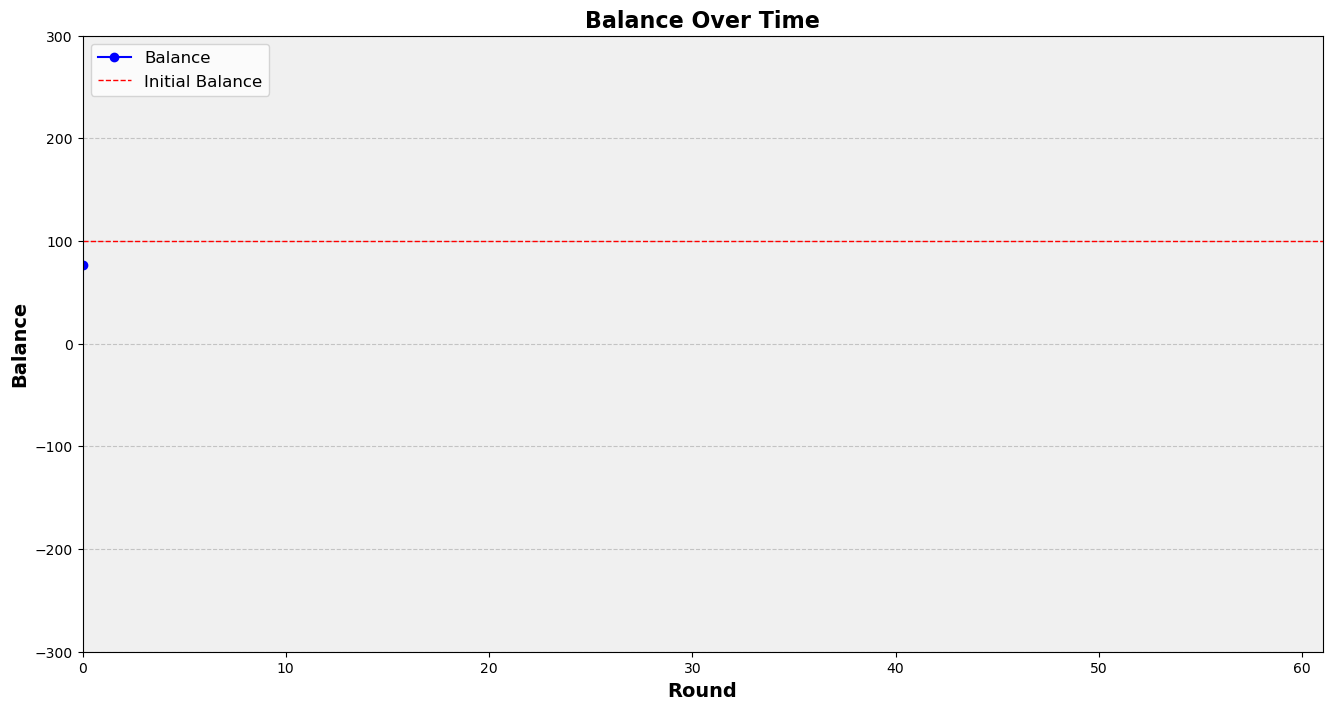

Balance after 1 rounds: 153.5


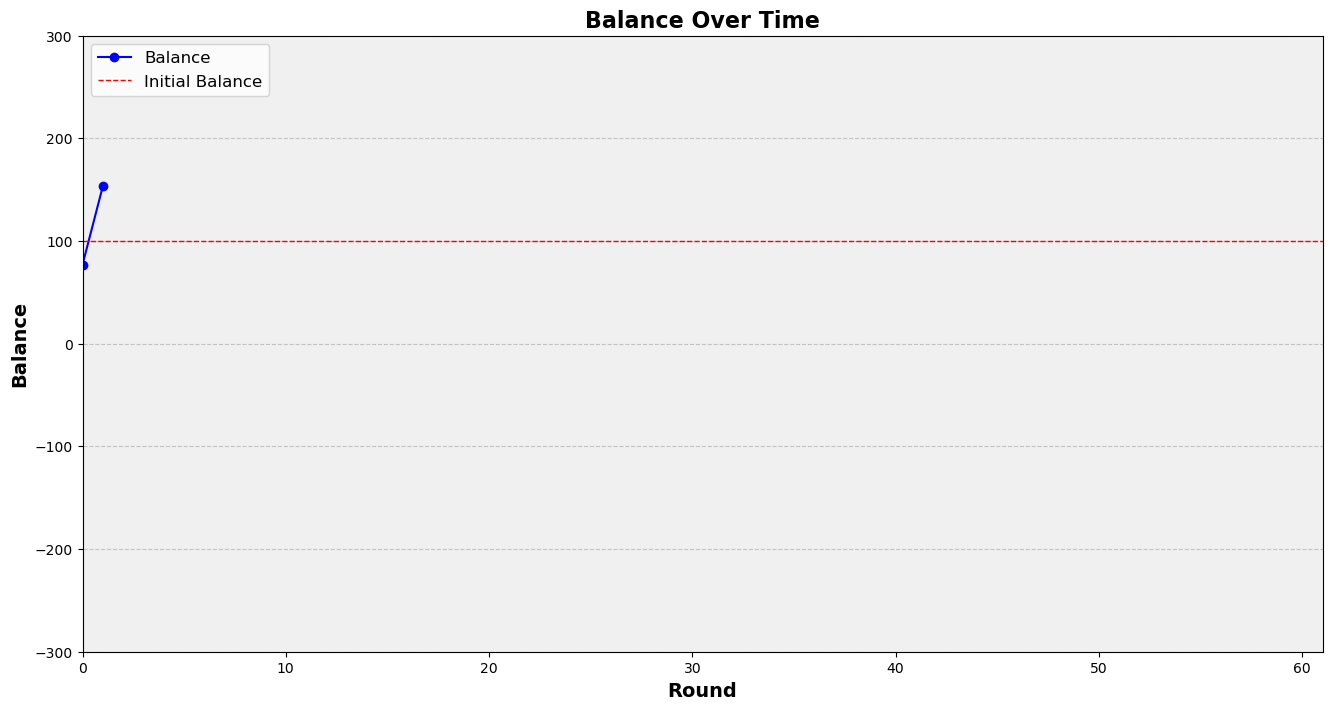

Balance after 2 rounds: 128.5


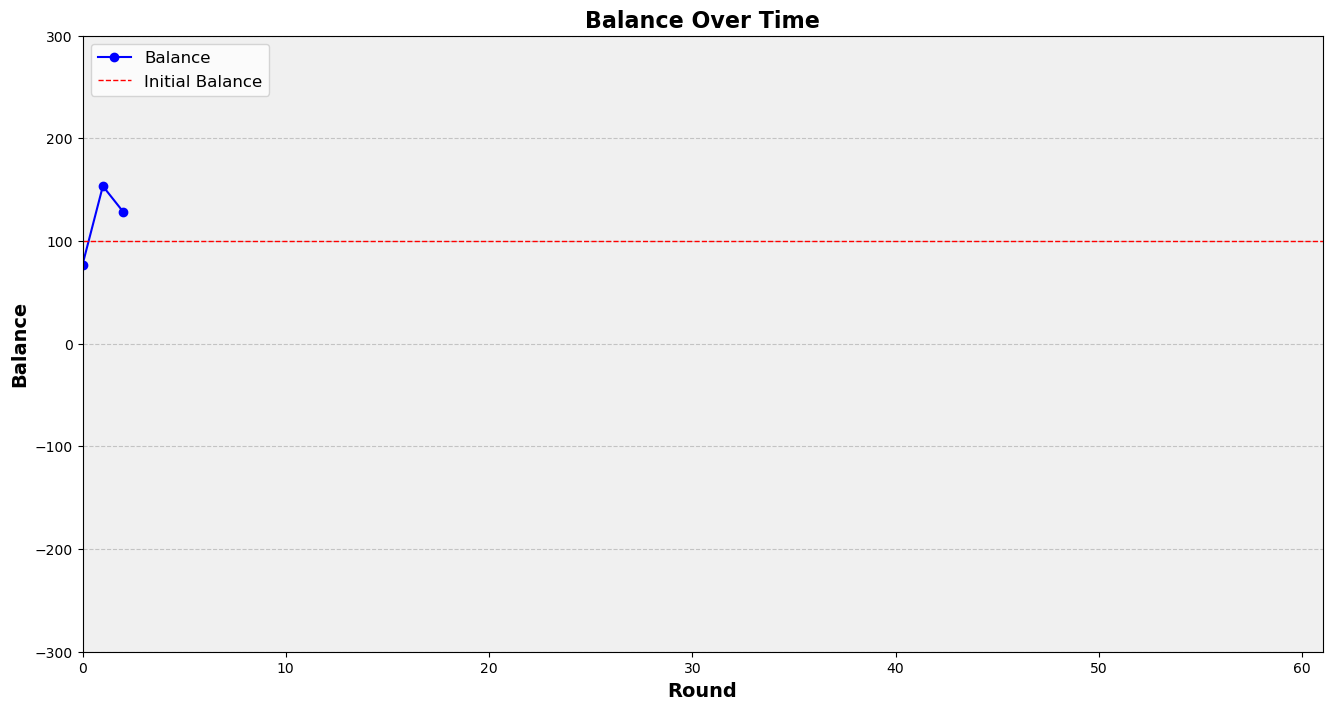

In [ ]:
train_ = train

def betting_result(prediction, real, home_odd, draw_odd, away_odd):
    if prediction == real:
        if prediction == 0:
            return away_odd
        elif prediction == 1:
            return draw_odd
        else:
            return home_odd
    else:
        return 0

balance = 100
balance_list = []
for i in range(0, int(np.round(len(valid)/10)) + 1):
    X = train_.drop(columns=["date", "match_result"])
    Y = train_["match_result"]
    x_train = X
    y_train = Y
    x_test = valid.iloc[i*10:i*10 + 10].drop(columns=["date", "match_result"])
    y_test = valid.iloc[i*10:i*10 + 10]["match_result"]
    betting_odds = valid.iloc[i*10:i*10 + 10][["B365H", "B365A", "B365D"]]
    x_train, x_test, y_train, y_test = preprocess_data(x_train, x_test, y_train, y_test)
    model = RandomForestClassifier(random_state=42)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_test_series = pd.Series(y_test)
    y_pred_series = pd.Series(y_pred, index=y_test_series.index)
    for j in range(10):
        balance -= 10
        balance += 10 * betting_result(y_pred_series.iloc[j], y_test_series.iloc[j], betting_odds.iloc[j]["B365H"], betting_odds.iloc[j]["B365D"], betting_odds.iloc[j]["B365A"])
    print(f"Balance after {i} rounds: {balance}")
    train_ = pd.concat([train_, valid.iloc[i*10:i*10 + 10]])
    if i == np.round(len(valid)/10):
        break
    balance_list.append(balance)
    # plot the results
    plt.figure(figsize=(16, 8))
    plt.plot(range(i + 1), balance_list, color='blue', linestyle='-', marker='o', markersize=6, label='Balance')
    plt.axhline(y=100, color='red', linestyle='--', linewidth=1, label='Initial Balance')
    plt.xlabel('Round', fontsize=14, fontweight='bold')
    plt.ylabel('Balance', fontsize=14, fontweight='bold')
    plt.xlim(0, int(np.round(len(valid)/10)))
    plt.ylim(-300, 300)
    plt.title('Balance Over Time', fontsize=16, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(loc='upper left', fontsize=12)
    plt.gca().set_facecolor('#f0f0f0')
    SAVE_PATH = Path() / "Figs" / "Balances"
    SAVE_PATH.mkdir(parents=True, exist_ok=True)

    plt.savefig(SAVE_PATH / f'balance_over_time_{i}.png', dpi=600)
    plt.show()